## Burgers by PINN
based on https://arxiv.org/pdf/2106.07606.pdf

При попытке обучить перцептрон на результатах научного эксперимента обычно получается что-то способное посторить зависимость в области присутствия данных, но не способное их предсказать, результат примерно такой(В данном примере рассматривается затухающий осцилятор):
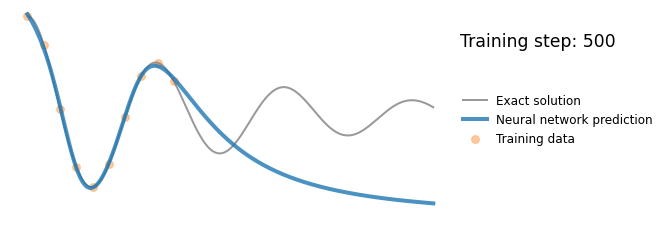

Это ещё одно напоминание, что процесс обучения не всегда способен установить настоящую зависимость между данными. Простая сеть не смогла обучится так, чтобы "понять" физический принцип и предсказать дальнейшие данные. Попробуем модифицировать её так, чтобы у нас получилось.

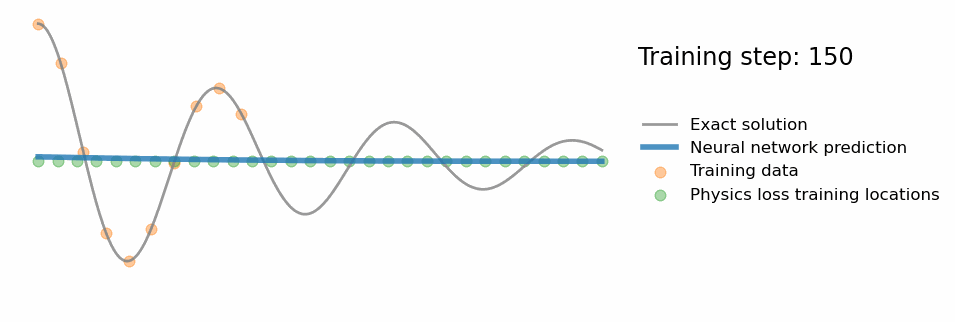

Добиться такого результата можно довольно простой и гениальной идеей: достаточно модифицировать функцию потерь так, чтобы в ней присутствовала исходная задача УМФ или ДУ:
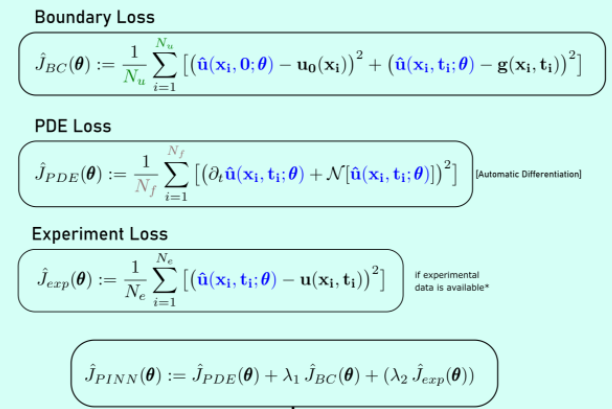

Попробуем решить уравнение Бюргерса используя PINN:
$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2} $$

# Import Libraries

In [6]:
import torch
import torch.autograd as autograd        
from torch import Tensor                  
import torch.nn as nn                    
import torch.optim as optim               

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
import seaborn as sns

import numpy as np
import time
from pyDOE import lhs        
import scipy.io


torch.set_default_dtype(torch.float)
torch.manual_seed(1234)
np.random.seed(1234)



In [7]:
!pip install pyDOE

# *Data Prep*

Взяли данные из матлаба и загрузили сайпаем.

In [8]:
data = scipy.io.loadmat('Data/burgers_shock_mu_005_pi.mat')  # Load data from legally questionable source
x = data['x']                                   
t = data['t']                                   
usol = data['usol']                             

X, T = np.meshgrid(x,t)                         

In [9]:
print(x.shape, t.shape, usol.shape)
print(X.shape, T.shape)


(256, 1) (100, 1) (256, 100)
(100, 256) (100, 256)


# Test Data

Тестовая выборка.

In [10]:
X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) 
print(X_u_test.shape)

lb = X_u_test[0] 
ub = X_u_test[-1] 

u_true = usol.flatten('F')[:,None] 

(25600, 2)


In [11]:
print(X.flatten()[:, None])
print(ub, lb, u_true.shape)

[[-1.        ]
 [-0.99215686]
 [-0.98431373]
 ...
 [ 0.98431373]
 [ 0.99215686]
 [ 1.        ]]
[1.   0.99] [-1.  0.] (25600, 1)


# Training Data

In [12]:
def trainingdata(N_u,N_f):

    #-1 <= x <= 1,    t = 0  
    leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) 
    leftedge_u = usol[:,0][:,None]
    print(leftedge_u[0:5], leftedge_x.shape, leftedge_u.shape, "\n") # IC - it is -sin(8*pi*x)

    #x = -1,   0 <= t <= 1
    bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) 
    bottomedge_u = usol[-1,:][:,None]
    print(bottomedge_u[0:5], bottomedge_x.shape, bottomedge_u.shape, " \n") # BC - it is zero

    #x = 1,   0 <= t <= 1
    topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) 
    topedge_u = usol[0,:][:,None]
    print(topedge_u[0:5], topedge_x.shape, bottomedge_u.shape, " \n") # BC - it is zero

    all_X_u_train = np.vstack([leftedge_x, bottomedge_x, topedge_x]) 
    all_u_train = np.vstack([leftedge_u, bottomedge_u, topedge_u])   
    print(all_X_u_train.shape, all_u_train.shape)

    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 

    X_u_train = all_X_u_train[idx, :] 
    u_train = all_u_train[idx,:]      


    X_f_train = lb + (ub-lb)*lhs(2,N_f) 
    X_f_train = np.vstack((X_f_train, X_u_train)) 

    return X_f_train, X_u_train, u_train 


# PINN architecture

In [13]:
model_train_loss = []
model_test_loss = []

class Sequentialmodel(nn.Module):
    
    def __init__(self, layers):
        super().__init__() 
              
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)
            

    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to('cpu')
        l_b = torch.from_numpy(lb).float().to('cpu')
                      
        x = (x - l_b)/(u_b - l_b) 
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)            
            a = self.activation(z)
            
        a = self.linears[-1](a)
        return a
                        
    def loss_BC(self, x, y):
        loss_u = self.loss_function(self.forward(x), y)
        return loss_u
    
    def loss_PDE(self, x_to_train_f):
        
        nu = 0.01/np.pi
                
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
                        
        g = x_to_train_f.clone()
        g.requires_grad = True
        
        u = self.forward(g)
        
        u_x_t = autograd.grad(u, g, torch.ones([x_to_train_f.shape[0], 1]).to('cpu'), retain_graph=True, create_graph=True)[0]                 
        u_xx_tt = autograd.grad(u_x_t, g, torch.ones(x_to_train_f.shape).to('cpu'), create_graph=True)[0]
                                                            
        u_x = u_x_t[:,[0]]
        u_t = u_x_t[:,[1]]
        
        u_xx = u_xx_tt[:,[0]]              
        f = u_t + (self.forward(g))*(u_x) - (nu)*u_xx 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,x,y,x_to_train_f):

        loss_u = self.loss_BC(x, y)
        loss_f = self.loss_PDE(x_to_train_f)
        
        loss_val = loss_u + loss_f
        return loss_val
     
                                       
    def closure(self):
        
        optimizer.zero_grad()
        loss = self.loss(X_u_train, u_train, X_f_train)
        loss.backward()
                
        self.iter += 1
        
        if self.iter % 10 == 0:
            error_vec, _ = PINN.test()
            model_train_loss.append(loss.item())
            model_test_loss.append(error_vec.item())
            #print(loss,error_vec)

        return loss        

    
    def test(self):
                
        u_pred = self.forward(X_u_test_tensor)
        error_vec = torch.linalg.norm((u-u_pred),2)/torch.linalg.norm(u,2)        
        
        u_pred = u_pred.cpu().detach().numpy()
        u_pred = np.reshape(u_pred,(256,100),order='F')
                
        return error_vec, u_pred

# *Solution Plot*

In [14]:
# I hated working with that
def solutionplot(u_pred,X_u_train,u_train):
    
    fig, ax = plt.subplots()
    ax.axis('off')
    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
               origin='lower', aspect='auto')

    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)
    
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,usol.T[25,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title('$t = 0.25s$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.50s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 0.75s$', fontsize = 10)
    
    plt.savefig('Burgers.png',dpi = 500)   

# Main

In [15]:
N_u = 100 
N_f = 10_000 
X_f_train_np_array, X_u_train_np_array, u_train_np_array = trainingdata(N_u,N_f)


X_f_train = torch.from_numpy(X_f_train_np_array).float().to('cpu')
X_u_train = torch.from_numpy(X_u_train_np_array).float().to('cpu')
u_train = torch.from_numpy(u_train_np_array).float().to('cpu')
X_u_test_tensor = torch.from_numpy(X_u_test).float().to('cpu')
u = torch.from_numpy(u_true).float().to('cpu')
f_hat = torch.zeros(X_f_train.shape[0],1).to('cpu')

layers = np.array([2,20,20,20,20,20,20,20,20,1]) 



[[1.22464680e-16]
 [2.46374492e-02]
 [4.92599411e-02]
 [7.38525275e-02]
 [9.84002783e-02]] (256, 2) (256, 1) 

[[-1.22464680e-16]
 [-1.68002433e-16]
 [-5.14386692e-16]
 [-2.39163098e-16]
 [-4.07989493e-16]] (100, 2) (100, 1)  

[[1.22464680e-16]
 [1.31850025e-16]
 [2.54493630e-16]
 [1.65906215e-16]
 [1.13575881e-16]] (100, 2) (100, 1)  

(456, 2) (456, 1)


Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Linear(in_features=20, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)
Training time: 78.39
Test Error: 0.12138


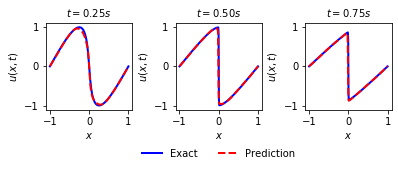

In [16]:
PINN = Sequentialmodel(layers)
PINN.to('cpu')

print(PINN)
params = list(PINN.parameters())


# LBFGS Option, personally I think it's doing okay
optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.1, 
                              max_iter = 1000, 
                              max_eval = None, 
                              tolerance_grad = 1e-05, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')

start_time = time.time()

optimizer.step(PINN.closure)
    
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

error_vec, u_pred = PINN.test()
print('Test Error: %.5f'  % (error_vec))

solutionplot(u_pred,X_u_train.cpu().detach().numpy(),u_train.cpu().detach().numpy())

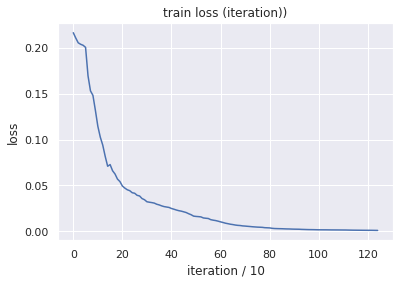

In [18]:
sns.set()
X = range(len(model_train_loss))
plt.plot(X, model_train_loss)
#sns.lineplot(x = X,y = Y_2)

plt.title('train loss (iteration))')
plt.xlabel('iteration / 10')
plt.ylabel('loss');

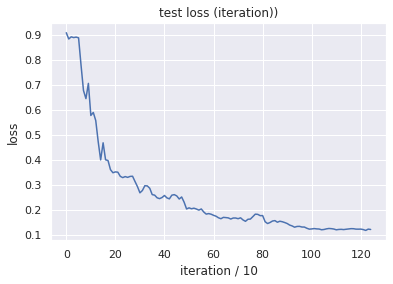

In [20]:
X = range(len(model_test_loss))
plt.plot(X, model_test_loss)
#sns.lineplot(x = X,y = Y_2)

plt.title('test loss (iteration))')
plt.xlabel('iteration / 10')
plt.ylabel('loss');